## Introduction
For this challenge we are tasked with validating various features for a model that attempts to predict property crime in cities across New York.  We have already cleaned this data and built multiple models in previous exercises.  

The next step will be to try the newly created model on data that we have not encountered yet - such as New York crime data from a previous year or crime data from another state altogether.

## Importing and cleaning the data

In [1]:
# importing pnadas modules
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn import linear_model
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

%matplotlib inline
#pd.options.display.float_format = '{:.3f}'.format
sns.set_style('white')

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [2]:
# importing raw data from excel into a pandas dataframe
df_raw = pd.read_excel('table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls')
# display raw file
df_raw.head()

,Table 8,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,NEW YORK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Offenses Known to Law Enforcement,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"by City, 2013",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,City,Population,Violent\ncrime,Murder and\nnonnegligent\nmanslaughter,Rape\n(revised\ndefinition)1,Rape\n(legacy\ndefinition)2,Robbery,Aggravated\nassault,Property\ncrime,Burglary,Larceny-\ntheft,Motor\nvehicle\ntheft,Arson3
4,Adams Village,1861,0,0,NaN,0,0,0,12,2,10,0,0


Drop some rows, rename some columns and square pop to get a pop2 column just in case we want to use this as a feature.   Also, convert data to float.

In [3]:
# setting the proper heading from the 4th row of raw data
headers = df_raw.iloc[3]

# exclude rows 1 through 4 (or rows 0, 1, 2, 3)
df_ny = pd.DataFrame(df_raw.values[4:], columns=headers)

# renaming columns
df_ny.columns = ['city', 'pop', 'vc', 'murder', 'rape1', 'rape2', 'robbery', 'aa', 'pc', 'burglary', 'lt', 'mvt', 'arson3']

# dropping unnecessary columns
df_ny = df_ny.drop(['vc', 'rape1', 'rape2', 'aa', 'burglary', 'lt', 'mvt', 'arson3'], axis=1)

# removing last 3 rows of instructional data
df_ny = df_ny.drop([348, 349, 350], axis=0)

#converting string values to float and creating 'pop2' column which is pop squared
df_ny["pop"] = [np.float(x) for x in df_ny["pop"]]
df_ny["pop2"] = [np.float(x*x) for x in df_ny["pop"]]
df_ny["murder"] = [np.float(x) for x in df_ny["murder"]]
df_ny["robbery"] = [np.float(x) for x in df_ny["robbery"]]
df_ny["pc"] = [np.float(x) for x in df_ny["pc"]]

# display data
df_ny.head()

,city,pop,murder,robbery,pc,pop2
0,Adams Village,1861.0,0.0,0.0,12.0,3.463321e+06
1,Addison Town and Village,2577.0,0.0,0.0,24.0,6.640929e+06
2,Akron Village,2846.0,0.0,0.0,16.0,8.099716e+06
3,Albany,97956.0,8.0,227.0,4090.0,9.595378e+09
4,Albion Village,6388.0,0.0,4.0,223.0,4.080654e+07


## Data exploration

From previous exercises, we know that NYC data is a significant outlier which overwhelms the model, so we are going to drop it for now to build the model.

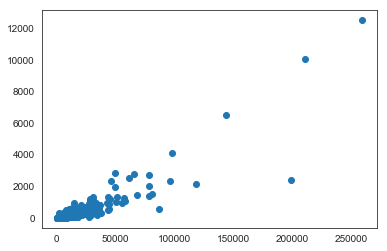

In [4]:
# drop nyc data
df_no_nyc = df_ny.drop([216])

# produce new scatterplot
plt.scatter(df_no_nyc['pop'], df_no_nyc['pc'])

This plot is the same as we have seen in the previous challenge.  Nothing new here.  The property crime for NYC is around 141,000 which we have dropped.

## Building the model

In [5]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = df_no_nyc['pc']
X = df_no_nyc[['pop','murder','robbery']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [1.58354338e-02 1.18437047e+02 2.02472175e+00]

Intercept: 
 25.21793454302474

R-squared:
0.9305586206386044


So, we now have an equation that predicts property crime from the input features of population, murder and robbery occurrences by city.  The only data manipulation we have done here is exclude NYC.  

Next, let's build a model where we convert the murder and robbery features to **categorical** (i.e. 0 for 0 occurances and 1 for anything greater than 0 occurences.

In [6]:
# If murders or robberies in greater than 0, convert to 1 else leave at 0
df_no_nyc['murder_c'] = df_no_nyc['murder'].apply(lambda x : 1 if x>0 else 0)
df_no_nyc['robbery_c'] = df_no_nyc['robbery'].apply(lambda x : 1 if x>0 else 0)
df_no_nyc.head()

,city,pop,murder,robbery,pc,pop2,murder_c,robbery_c
0,Adams Village,1861.0,0.0,0.0,12.0,3.463321e+06,0,0
1,Addison Town and Village,2577.0,0.0,0.0,24.0,6.640929e+06,0,0
2,Akron Village,2846.0,0.0,0.0,16.0,8.099716e+06,0,0
3,Albany,97956.0,8.0,227.0,4090.0,9.595378e+09,1,1
4,Albion Village,6388.0,0.0,4.0,223.0,4.080654e+07,0,1


In [7]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = df_no_nyc['pc']
X = df_no_nyc[['pop','murder_c','robbery_c']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [ 3.43860764e-02  1.43473775e+01 -9.42521334e+01]

Intercept: 
 -108.42335403478899

R-squared:
0.7889428000907828


As you can see we have a different coefficients, intercept and r-squared values from the previous model.  We need to run some tests to see which model is better.

## Evaluating the model

For the first case - where we are keeping the features as is - let's check to see if any of the features can be dropped becuase of irrelevancy.

In [8]:
# Creating the model formula
# Use a ~ to represent an '=' from the functional form
linear_formula = 'pc ~ pop+murder+robbery'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=df_no_nyc).fit()

Check the parameters, pvalues and r-squared value.

In [9]:
lm.params

Intercept     25.217935
pop            0.015835
murder       118.437047
robbery        2.024722
dtype: float64

In [10]:
lm.pvalues

Intercept    1.771582e-01
pop          1.100236e-45
murder       4.808789e-14
robbery      2.481759e-03
dtype: float64

In [11]:
lm.rsquared

0.9305586206386043

This looks great.  All of out p values are less than .05 which likely means they are all adding predictive value to the model.  The r-squared value is still **0.93** and not too close to 1 which makes it less likely we have overfit the data.  

Now, let's look at the case where we converted the murder and robbery data to categorical and compare the results with the raw data (excluding NYC of course).

In [12]:
# Creating the model formula
# Use a ~ to represent an '=' from the functional form
linear_formula = 'pc ~ pop+murder_c+robbery_c'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=df_no_nyc).fit()

In [13]:
lm.params

Intercept   -108.423354
pop            0.034386
murder_c      14.347378
robbery_c    -94.252133
dtype: float64

In [14]:
lm.pvalues

Intercept     8.205933e-03
pop          7.517475e-100
murder_c      8.692678e-01
robbery_c     9.624259e-02
dtype: float64

In [15]:
lm.rsquared

0.7889428000907827

As suspected, here we have a problem.  The p values for murder and robbery are **0.87 and 0.10**, respectively.  They are definitely greater than .05 and can be withdrawn from the model.  

Let's withdraw murder and robbery altogether and compare the r-squared value with our r-squared value when leaving all 3 features in the model in their original form.

In [16]:
# Creating the model formula
# Use a ~ to represent an '=' from the functional form
linear_formula = 'pc ~ pop'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=df_no_nyc).fit()

In [17]:
lm.params

Intercept   -155.020489
pop            0.033890
dtype: float64

In [18]:
lm.pvalues

Intercept     3.340745e-07
pop          5.644411e-118
dtype: float64

In [19]:
lm.rsquared

0.7872222002523548

## Discussion and conclusion
From our first attempt to build a model in this notebook we got the equation:  **y = 25.2 + .016(pop) + 118.4(murder) + 2.0(robbery)**  

This was obtained by first dropping NYC data and then using the three features as is to build the model.  The r-squared value equaled **.931** and all of the features were significant in measuring the variance of the outcome.  

Next, we built the model by converting the murder and robbery features to categorical to see if that changed the accuracy of the model.  We got an equation of:  **y = -108.4 + 14.3(pop) + 14.3(murder) -94.3(robbery)**  

The r-squared value in this case was **.789** which is much less than our previous **.931**.  We also determined that the 2 categorical features did not add any value to the model becuase their p-values were greater than .05 and we proved this by removing the categorical features and calculated a new r-squared value of **.787** -- practically the same thing as when the 2 features were included in the model.  

In this case, converting murder and robbery values to categorical features weakened the predictive power of our model and as it turns out, became insignificant in explaining any variance of the outcome.